# Homework 3

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Mark Hendricks
* hendricks@uchicago.edu

***

# 1 HBS Case: Fixed-Income Arbitrage in a Financial Crisis (C): Spread and Swap Spread in November 2008

## Simplification of the setup

The date is Nov 4, 2008.

**Treasury bond**
* Suppose the Treasury bond matures exactly 30 years later, on Nov 4, 2038 rather than May 15, 2008. 
* The YTM of this freshly issued treasury is 4.193\% with a semiannual coupon of 4.50\%, same as is given in the case. (So we're just changing the maturity date to simplify things, but keeping the market data.)

**Swap**
* The fixed leg of the swap pays semiannually, with swap rate of 4.2560\%, as given in the case.
* The floating leg of the swap also pays semiannually--not quarterly--such that the payment dates are identical on both legs. Thus, it also resets the floating rate semiannually, not quarterly.
* The floating rate of the swap equals the repo rate used in the trade. Thus, these two rates cancel in the financing of the trade. (No need to consider the TED spread.) 

## Case Clarifications


### Duration Quotes
Bond
* Quote: Val01 of bond is .1746 per bp per $1 face value
* Class terminology: Modified dollar duration is .1746 per $100 face value

Swap
* Quote: DV01 of swap is 1.7mm per 1 billion notional.
* Class terminology: Modified dollar duration is 100(1.7/1000) per $100 face value.

Thus, modified dollar duration for each per 100 face is
* Bond = .1746
* Swap = .1700

### Hedge Ratio

In figuring out the hedge ratio, they set up the hedge per dollar of face value. 

    *so Mills would need to buy face amount $0.97 billion*
    
No, this hedge should be for market value, not face amount given that the case is already using **modified** duration which includes the dirty price.
    

### Maturity Mismatch

The maturity of the bond is August 2038, whereas the date is Nov 2008. Thus, the bond has less than 30 years to maturity, yet he is entering a 30-year swap. 

For simplicity, we imagine the bond is issued in Nov 2008 and thus has maturity of 30 years at the time of the case.

However, then the case quotes for the Nov price and YTM of the bond no longer are accurate. Use one and adjust the other. Namely, we could...
    * use the Nov 4 **YTM** quoted in the case, and re-adjust the the bond.
    * use the Nov 4 **price** quoted in the case, and re-adjust the YTM.
    
We do the former, keep the quoted YTM, assume time-to-maturity of `30`, and recalculate the Nov 2008 price. (It is close to the quoted price in the case.)

***

In [1]:
import numpy as np
import pandas as pd


def duration_closed_formula(tau, ytm, cpnrate=None, freq=2):

    if cpnrate is None:
        cpnrate = ytm
        
    y = ytm/freq
    c = cpnrate/freq
    T = tau * freq
        
    if cpnrate==ytm:
        duration = (1+y)/y  * (1 - 1/(1+y)**T)
        
    else:
        duration = (1+y)/y - (1+y+T*(c-y)) / (c*((1+y)**T-1)+y)

    duration /= freq
    
    return duration

## 1.0.

Report the price of the 30-year T-bond in Nov 2008. Given the discussion about `Maturity Mismatch`, we are repricing the bond, so it will not exactly equal `105` as reported in the case.

Given that: $t_0 =$ Nov 4,2008 ; $T =$ Nov 4, 2038 ; YTM = 4.193\% ; Semiannual coupon of 4.50\%. Then, the price of the bond is 

$$ P = \sum_{t = 1}^{60} \frac{4.5/2}{(1+4.193\%/2)^t} +  \frac{100 + 4.5/2}{(1+4.193\%/2)^{60}}  $$

In [2]:
y = 4.193/200
c = 4.5/2
T = range(1, 60, 1)

p = 0

for t in T:
    p += (1/(1+y)**t)*c
p += (1/(1+y)**60)*(c+100)

print(p)

105.21328175314193


## 1.1

List the projected cashflows on May 4, 2009, exactly six months into the trade, on the first coupon and swap date.

#### Clarification
List these cashflows for face value of $1B, not the $0.97B noted in the case. As mentioned in "Case Clarifications", we will not use this number. Rather, we calculate our own hedge ratio in a problem below.

In [3]:
data = pd.DataFrame(index=["Bond", "Swap_Fixed", "Swap_Float", "Repo"], columns= ["Coupon", "Yield", "Price", "Duration"])
haircut = 0.02

data.loc["Bond"] = [c*2/100, y*2, p, 17.46]
data.loc["Swap_Fixed"] = [4.2560/100, np.nan, 100, 17]
data.loc["Swap_Float"] = [np.nan, np.nan, 100, 0.5]
data.loc["Repo"] = [np.nan, np.nan, p*(1-haircut), 0.5]


display(data)

FV = 1000

,Coupon,Yield,Price,Duration
Bond,0.045,0.04193,105.213282,17.46
Swap_Fixed,0.04256,NaN,100,17
Swap_Float,NaN,NaN,100,0.5
Repo,NaN,NaN,103.109016,0.5


In [4]:
print("CF in six months......")
print(f"Notional of the Swap: {FV:.2f} millions")
print(f"Notional of the Bond: {FV:.2f} millions")
print(f"Pay fixed rate Swap: {-data.loc["Swap_Fixed", "Coupon"]*FV/200:.3f} millions")
print(f"Recieved a fixed rate from the bond : {data.loc["Bond", "Coupon"]*FV/200:.3f} millions")
print(f"Net payment: {(-data.loc["Swap_Fixed", "Coupon"]*FV/200 + data.loc["Bond", "Coupon"]*FV/200):.3f} millions")

CF in six months......
Notional of the Swap: 1000.00 millions
Notional of the Bond: 1000.00 millions
Pay fixed rate Swap: -0.213 millions
Recieved a fixed rate from the bond : 0.225 millions
Net payment: 0.012 millions


## 1.2

What is the duration of...
* the T-bond
* the swap

Remember that...
* the swap can be decomposed into a fixed-rate bond and a floating-rate note
* a floating-rate note has duration equal to the time until the next reset. Thus, at initialization, it has duration equal to 0.5 years.

Is the duration for the "paying-fixed" swap positive or negative? Is it bigger or smaller in magnitude than the T-bond?

For this problem, calculate the Macauley duration and the dollar (Macauley) duration.

In [5]:
data.loc["Bond","Macauley_duration"] = duration_closed_formula(30, data.loc["Bond","Yield"], data.loc["Bond","Coupon"], 2)
data.loc["Swap_Fixed","Macauley_duration"] = duration_closed_formula(30,  data.loc["Swap_Fixed","Coupon"])
data.loc["Swap_Float","Macauley_duration"] = 0.5
data.loc["Repo","Macauley_duration"] = 0.5

data["Dollar_Duration"] = data["Macauley_duration"] * data["Price"]

display(data[['Macauley_duration', 'Dollar_Duration']])


,Macauley_duration,Dollar_Duration
Bond,17.083633,1797.4251
Swap_Fixed,17.212744,1721.274445
Swap_Float,0.500000,50.0
Repo,0.500000,51.554508


In [6]:
net_position = pd.DataFrame(index=["T Repo", "Swap"], columns= ["Macauley_duration", "Dollar_Duration"])
net_position.loc["T Repo"] = data.loc["Bond", ['Macauley_duration', 'Dollar_Duration']] - data.loc["Repo", ['Macauley_duration', 'Dollar_Duration']]
net_position.loc["Swap"] = data.loc["Swap_Fixed", ['Macauley_duration', 'Dollar_Duration']] - data.loc["Swap_Float", ['Macauley_duration', 'Dollar_Duration']]
net_position.loc["Net_Position"] = net_position.loc["T Repo"] - net_position.loc["Swap"]
net_position

,Macauley_duration,Dollar_Duration
T Repo,16.583633,1745.870591
Swap,16.712744,1671.274445
Net_Position,-0.129111,74.596146


In this problem, the duration of the Swap is negative, because we are paying fixed rate. Now, because we are assumming that the Repo and the Floating Rate pays every 6 months, actually these cancels out. So, the net position is the same as the bond (reciving) and swap (paying).

## 1.3

What hedge ratio should be used to balance the notional size of the Treasury bond with the notional size of the swap, such that it is a duration-neutral position?

Specifically, if the trader enters the swap paying fixed on \$500 million notional, how large of a position should they take in the Treasury bond?

In [7]:
hedge = (net_position.loc["Swap","Dollar_Duration"]/net_position.loc["T Repo","Dollar_Duration"])
hedge

0.9572728091202432

In [8]:
hedge = (net_position.loc["Swap","Dollar_Duration"]/net_position.loc["T Repo","Dollar_Duration"])
hedge = 0.95
position_swap = -500e6
position_bond = -position_swap*hedge

print(f"Position in Swap: {position_swap:,.2f}")
print(f"Position in Bond: {position_bond:,.2f}")

Position in Swap: -500,000,000.00
Position in Bond: 475,000,000.00


## 1.4

Suppose it is May 4, 2009, exactly six months after putting the trade on.

The spread is at -28 bps due to...
* The YTM on a new 30-year bond has risen to 4.36\%
* The swap rate on a new 30-year swap has dropped to 4.08\%

Explain conceptually how this movement impacts the components of the trade.

*Answer :*

- In this case, because we're paying fixed rate in the swap, and the swap rate drops, we're losing money in the swap since we're paying more than the market rate.
- On the other hand, we're holding a bond and the yield risen, so the price of the bond drops, we're losing money in the bond as well.
- The floating rate of the swap and the repo cancel each other out, so we don't need to consider them in the delta position calculation.

## 1.5

Calculate the value of the position on May 4, 2009, immediately after the first coupon and swap payments and swap reset. 

* Calculate the revised price of the Treasury bond by assuming you can apply the (May 4) 30-year YTM as a discount rate to the 29.5 year bond. (We are just using this for a rough approximation. You know that good pricing would require a discount curve, but let's not get bogged down with that here.)


* Calculate the value of the swap by decomposing it into a fixed-rate bond and a floating-rate bond.
    * The 29.5 year fixed-rate leg is priced using the (May 4) 30-year swap rate as a discount rate.
    * The floating-rate leg is priced at par given that floating-rate notes are par immediately after resets.
    
**Note**

You are being asked to calculate these valuations using the exact formula between price, cashflows, and YTM discount rate. We are not simply approximating with duration, as we already know the position was set up with zero dollar duration.

From the Discussion notebook, we have this formula expressing a bond's price as a function of the coupon, $c$, and the YTM, $y_j$.

$\begin{align}
P_j(t,T,c) = \sum_{i=1}^{n-1}\frac{100\left(\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T_i-t)}} + \frac{100\left(1+\frac{c}{2}\right)}{\left(1+\frac{y_j}{2}\right)^{2(T-t)}}
\end{align}
$

In [9]:
y = 4.36/200
c = 4.5/2
T = range(1, 59, 1)

p_new = 0

for t in T:
    p_new += (1/(1+y)**t)*c
p_new += (1/(1+y)**59)*(c+100)

print(f"New price of the bond: {p_new:.2f}")
print(f"Profit: {p_new - data.loc['Bond', 'Price']:.2f}")

New price of the bond: 102.31
Profit: -2.90


In [10]:
y_swap = 4.08/200
c_swap = 4.256/2
T = range(1, 59, 1)

p_new_swap = 0

for t in T:
    p_new_swap += (1/(1+y_swap)**t)*c_swap
p_new_swap += (1/(1+y_swap)**59)*(c_swap+100)

print(f"New price of the Swap: {p_new_swap:.2f}")
print(f"Profit: {-(p_new_swap - data.loc['Swap_Fixed', 'Price']):.2f}")

New price of the Swap: 103.00
Profit: -3.00


## 1.6

Accounting for the change in value of the positions, as well as the 6-month cashflows paid on May 4, 
* what is the net profit and loss (pnl) of the position?
* what is the return on the equity capital, considering that there was a 2\% haircut (equity contribution) on the size of the initial treasury bond position.

In [11]:
coupons_cash_flows = position_bond * c/100 + position_swap * c_swap/100
print(f"Net cash flow from coupons: {coupons_cash_flows:,.2f}")

Net cash flow from coupons: 47,500.00


In [12]:
price_change = (position_bond/p * (p_new - p)) + position_swap * (p_new_swap - 100)/100
print(f"Price change: {price_change:,.2f}")

Price change: -28,117,692.87


In [13]:
total_pnl = coupons_cash_flows + price_change
print(f"Total PnL: {total_pnl:,.2f}")


Total PnL: -28,070,192.87


In [14]:
print(f"Return on Capital: {total_pnl/(position_bond*p*haircut):.2%}")

Return on Capital: -2.81%


***

# 2. Factor Duration

### Data

This problem uses data from,
* `/data/yields.xlsx`
* `/data/treasury_ts_duration_2024-10-31.xlsx`

#### Load Yields

In [15]:
filepath = '../../data/yields.xlsx'
yields = pd.read_excel(filepath, sheet_name='yields')
yields.set_index('caldt',inplace=True)
yields.head()

,1,2,5,7,10,20,30
caldt,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049
1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543
1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018


#### Load Prices and Durations of Two Treasuries

In [16]:
QUOTE_DATE = '2024-10-31'
filepath = f'../../data/treasury_ts_duration_{QUOTE_DATE}.xlsx'

data = pd.read_excel(filepath,sheet_name='database')
data_info =  data.drop_duplicates(subset='KYTREASNO', keep='first').set_index('KYTREASNO')
data_info[['type','issue date','maturity date','cpn rate']]

,type,issue date,maturity date,cpn rate
KYTREASNO,,,,
207391,note,2019-08-15,2029-08-15,1.625
207392,bond,2019-08-15,2049-08-15,2.250


You will largely focus on the sheets which give the timeseries of prices and durations for each of the two securities, as shown in the following code.

In [17]:
SHEET_PRICE = 'price'
SHEET_DURATION = 'duration'
INDEX_NAME = 'quote date'

price = pd.read_excel(filepath,sheet_name=SHEET_PRICE).set_index(INDEX_NAME)
duration = pd.read_excel(filepath,sheet_name=SHEET_DURATION).set_index(INDEX_NAME)

### 2.1.

Construct the following yield-curve factors from the `yields` data set:

$\begin{align}
x^{\text{level}}_t =& \frac{1}{N_{\text{yields}}}\sum_{i=1}^{N_{\text{yields}}} y^{(i)}_t\\
x^{\text{slope}}_t =& y^{(30)}_t - y^{(1)}_t\\
x^{\text{curvature}}_t =& -y^{(1)}_t + 2 y^{(10)}_t - y^{(30)}_t
\end{align}$

In [18]:
yields["Level"] = yields.mean(axis=1)
yields["Slope"] = yields[30] - yields[1]
yields["Curvature"] = -yields[1] + 2*yields[10] - yields[30] 

yields.head()

,1,2,5,7,10,20,30,Level,Slope,Curvature
caldt,,,,,,,,,,
1961-06-14,2.935907,3.360687,3.623677,3.768720,3.818819,3.814210,3.815172,3.591027,0.879264,0.886559
1961-06-15,2.932936,3.376460,3.671691,3.804225,3.862987,3.828220,3.826316,3.614691,0.893380,0.966721
1961-06-16,2.929949,3.375670,3.685431,3.804216,3.863282,3.832922,3.830049,3.617360,0.900101,0.966566
1961-06-19,2.920884,3.389970,3.712984,3.824557,3.886205,3.842378,3.837543,3.630646,0.916659,1.013983
1961-06-20,2.952419,3.355796,3.685391,3.809274,3.886506,3.856465,3.845018,3.627267,0.892599,0.975574


### 2.2

Get the bond prices and durations for the two bonds in the data set referenced above.

#### Align the data

Align the bond pricing data with the yield factor data, so that you have data for both in the intersection of their dates.


#### Estimate the regression

Estimate the regression in the form of day-over-day differences for both bond prices and factors. That is, we are using regression to approximate the factor duration equation,

$\begin{align}
\frac{dP}{P} = \alpha + \beta_L dx_{\text{level}} + \beta_S dx_{\text{slope}} + \beta_C dx_{\text{curvature}} + \epsilon
\end{align}$

Report the betas for each of these factors, for each of the bond prices.

In [19]:
data = pd.merge(duration, price, left_index=True, right_index=True, how='inner', suffixes=('_duration', '_price'))
data[["207391_price", "207392_price"]] = data[["207391_price", "207392_price"]].pct_change()
data = pd.merge(data, yields[["Level", "Slope", "Curvature"]], left_index=True, right_index=True, how='left')
data[["Level", "Slope", "Curvature"]] =  data[["Level", "Slope", "Curvature"]].diff()
data.dropna(inplace=True)

In [23]:
import statsmodels.api as sm

X = data[["Level", "Slope", "Curvature"]]
X = sm.add_constant(X)
y = data["207391_price"]
model = sm.OLS(y, X).fit()
betas = model.params
betas

const        0.000064
Level       -0.069938
Slope       -0.004759
Curvature   -0.010926
dtype: float64

In [24]:
y = data["207392_price"]
model2 = sm.OLS(y, X).fit()
betas2 = model2.params
betas2

const        0.000069
Level       -0.197983
Slope       -0.126491
Curvature    0.074870
dtype: float64

### 2.3.

Compare the "level" factor beta for each of the two treasuries with the average  duration for each bond as reported in the data set.

* How closely does the average duration for a bond compare to its "level" beta?
* What do you conclude about the usefulness of mathematical duration vs regression sensitivities?

In [25]:
print(f"Mean duration bond 207391: {data['207391_duration'].mean():.2f}")
print(f"Estimated Level for bond 207391: {-betas['Level']*100:.2f}")
print(f"Difference: {data['207391_duration'].mean() + betas['Level']*100:.2f}")
print(f"Error estimation of Duration/Level: {(data['207391_duration'].mean() + betas['Level']*100)/data['207391_duration'].mean():.2%}")
print("--------------------")
print(f"Mean duration bond 207392: {data['207392_duration'].mean():.2f}")
print(f"Estimated Level for bond 207392: {-betas2['Level']*100:.2f}")
print(f"Difference: {data['207392_duration'].mean() + betas2['Level']*100:.2f}")
print(f"Error estimation of Duration/Level: {(data['207392_duration'].mean() + betas2['Level']*100)/data['207392_duration'].mean():.2%}")

Mean duration bond 207391: 6.92
Estimated Level for bond 207391: 6.99
Difference: -0.07
Error estimation of Duration/Level: -1.04%
--------------------
Mean duration bond 207392: 19.90
Estimated Level for bond 207392: 19.80
Difference: 0.10
Error estimation of Duration/Level: 0.52%


Even when the Level regressor is significant, the error estimation is too high. The model is not good enough to estimate the duration of the bond and since we have a closed formula to calculate the duration, we can use it to estimate the duration of the bond.

### 2.4.

In the duration-hedged trade of `Homework 2, Section 2`, was the that trade was long or short this slope factor? 

Do you think the slope factor exposure had a large impact on the trade?

No new analysis needed, just draw a conclusion from the estimates above along with the trade construction in `HW 2, Sec 2`.

*Answer :*

- Since in HW2.Sec2 we were buying (long) bond 207391 and selling (short) bond 207392, we were "selling" the slope of the yield curve
- And since the slope of this trade is large (because the price of the bond 207392 is more sensitive to the slope of the yield curve than the price of the bond 207391), in fact the slope exposure is important
- So, we should that into account the slope exposure in our hedge construction and not only the level exposure, in order to have a better hedge

***

# 3 Calculating Duration Via Individual Cashflows

## *Optional, not submitted*

Use the data file `../data/treasury_quotes_2024-10-31.xlsx`.

### 3.1 
Set up the cashflow matrix. 

In [1]:
import pandas as pd
import numpy as np
import Help_Functions as hf

path = "../../data/treasury_quotes_2024-10-31.xlsx"
quotes = pd.read_excel(path, sheet_name='quotes').set_index("KYTREASNO")
t_current = quotes['quote date'].values[0]

path = "../../data/treasury_quotes_crsp_2024-10-31.xlsx"
rawdata = pd.read_excel(path,sheet_name='quotes')
rawdata.columns = rawdata.columns.str.upper()
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)



In [2]:
RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = hf.filter_treasuries(quotes, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)
CF = hf.filter_treasury_cashflows(hf.calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)
prices = quotes.loc[CF.index,"dirty price"]

In [3]:
display(CF.head())  

,2024-11-05,2024-11-07,2024-11-12,2024-11-14,2024-11-15,2024-11-19,2024-11-21,2024-11-26,2024-11-29,2024-11-30,...,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15,2054-08-15
KYTREASNO,,,,,,,,,,,,,,,,,,,,,
208246,100.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208222,0.0,100.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208247,0.0,0.0,100.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208223,0.0,0.0,0.0,100.0,0.00,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
204083,0.0,0.0,0.0,0.0,103.75,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3.2
Extract the Nelson-Siegel spot discount curve, as you did in `Homework 1`.

In [4]:
AVG_LEVEL = .045
AVG_SLOPE = -.005
FIRST_HUMP = .01
FIRST_DECAY = 2
SECOND_HUMP = -.01
SECOND_DECAY = 2

x0 = np.array([AVG_LEVEL, AVG_SLOPE, FIRST_HUMP, FIRST_DECAY])

res = hf.estimate_nelson_siegel_models(CF = CF, t_current = t_current, prices = prices, x0_ns = x0, x0_nse=np.array([SECOND_HUMP, SECOND_DECAY]), return_modeled_prices = True)
display(res["params"])


DF_ns = res['DF_ns']
DF_nse = res['DF_nse']


DF_ns["Continuously_Rate"] = -np.log(DF_ns["Discount Factor"])/DF_ns.index
DF_ns["SemiAnual_Rate_NS"] = hf.compound_rate(DF_ns["Continuously_Rate"],None,2)

DF_nse["Continuously_Rate"] = -np.log(DF_nse["Discount Factor"])/DF_nse.index
DF_nse["SemiAnual_Rate_NSE"] = hf.compound_rate(DF_nse["Continuously_Rate"],None,2)

,theta 0,theta 1,theta 2,lambda_1,theta_3,lambda_2
Nelson-Siegel,0.04789,-0.002237,-0.020374,2.126947,None,None
Nelson-Siegel Extended,0.047856,-0.003926,-0.838928,1.613879,0.821665,1.598023


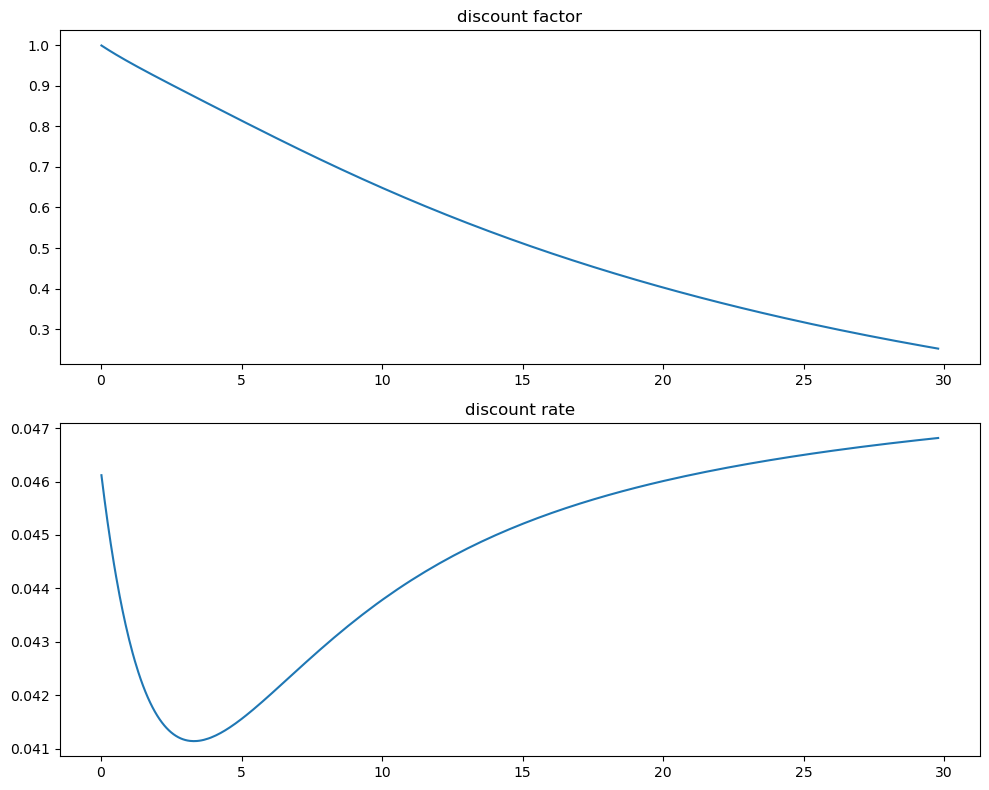

In [5]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(2,1,figsize=(10,8))
DF_ns['Discount Factor'].plot(ax=ax[0],title='discount factor');
DF_ns['SemiAnual_Rate_NS'].plot(ax=ax[1],title = 'discount rate');
plt.tight_layout()

### 3.3
For each treasury issue, calculate the duration as the weighted average of the (discounted!) cashflow maturity.

Report the summary statistics of the durations. (Use `.describe()` from pandas.)

In [6]:
wts = CF.mul(DF_ns['Discount Factor'].values,axis=1)
wts = wts.div(wts.sum(axis=1),axis=0)
duration = pd.DataFrame(wts @ DF_ns.index, index=wts.index, columns=["Duration"])
duration.describe()

,Duration
count,395.000000
mean,4.945647
std,5.350579
min,0.013689
25%,0.910377
50%,2.765600
75%,6.308805
max,19.624963


### 3.4
How close are your duration estimates to the imputed durations given in the data source?

Report the summary statistics of the imputed durations minus your calculated durations from above.

In [9]:
duration['errors'] = (rawdata['TDDURATN']/365.25  - duration['Duration']).abs()

In [10]:
duration['errors'].describe()

count    395.000000
mean       0.017318
std        0.047710
min        0.000000
25%        0.000003
50%        0.000090
75%        0.002006
max        0.305838
Name: errors, dtype: float64

### 3.5
Continue using your assumed discount rates of `4.5`\% to calculate the convexity of each issue.

Report the summary statistics of these convexity calculations.

In [43]:
duration['convexity'] = wts @ (DF_ns.index)**2

In [44]:
duration.describe()

,Duration,errors,convexity
count,395.000000,395.000000,395.000000
mean,4.945647,0.017318,65.508051
std,5.350579,0.047710,115.053633
min,0.013689,0.000000,0.000187
25%,0.910377,0.000003,0.830817
50%,2.765600,0.000090,7.938260
75%,6.308805,0.002006,42.099827
max,19.624963,0.305838,460.697982


***